In [17]:
!pip install ultralytics

In [120]:
import cv2
import numpy as np
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import display, HTML
import os

In [134]:
input_path = "/content/vid.mp4"
output_path = "tracked_person_route.mp4"

In [135]:
model = YOLO("yolov8n.pt")  # Using YOLO version 8 nano model

In [136]:
cap = cv2.VideoCapture(input_path)

In [137]:
# Get video properties
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

In [138]:
# Create video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

In [139]:
track_history = {}  # Dictionary to store tracking history
route_mask = np.zeros((height, width, 3), dtype=np.uint8)

In [140]:
ret, frame = cap.read()

In [141]:
results = model.track(frame, persist=True, classes=[0])  # Class 0 is person in COCO dataset
boxes = results[0].boxes.xyxy.cpu().numpy()
track_ids = results[0].boxes.id

if track_ids is not None:
    track_ids = track_ids.cpu().numpy().astype(int)
    num_persons = len(track_ids)
else:
    num_persons = 0


0: 384x640 35 persons, 16.2ms
Speed: 2.3ms preprocess, 16.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


In [142]:
# person_colors = {}
# R = 255
# G = 0
# B = 0
# for i in range(1, num_persons + 1):
#   R = R - 10
#   G = G + 5
#   B = B + 15
#   person_colors[i] = (R, G, B)

In [143]:
person_colors = {
    1 : (0,255,0)
}

Detected 35 people with the following IDs:
Person 1: Position (1001, 369)
Person 2: Position (987, 266)
Person 3: Position (469, 499)
Person 4: Position (1214, 139)
Person 5: Position (524, 357)
Person 6: Position (194, 348)
Person 7: Position (794, 676)
Person 8: Position (818, 131)
Person 9: Position (490, 208)
Person 10: Position (154, 67)
Person 11: Position (740, 64)
Person 12: Position (607, 101)
Person 13: Position (1088, 47)
Person 14: Position (399, 222)
Person 15: Position (1133, 49)
Person 16: Position (582, 88)
Person 17: Position (547, 92)
Person 18: Position (1158, 120)
Person 19: Position (791, 142)
Person 20: Position (981, 529)
Person 21: Position (635, 160)
Person 22: Position (77, 126)
Person 23: Position (498, 37)
Person 24: Position (249, 46)
Person 25: Position (1073, 45)
Person 26: Position (1066, 46)
Person 27: Position (1165, 105)
Person 28: Position (673, 110)
Person 29: Position (881, 39)
Person 30: Position (941, 61)
Person 31: Position (1083, 47)
Person 32:

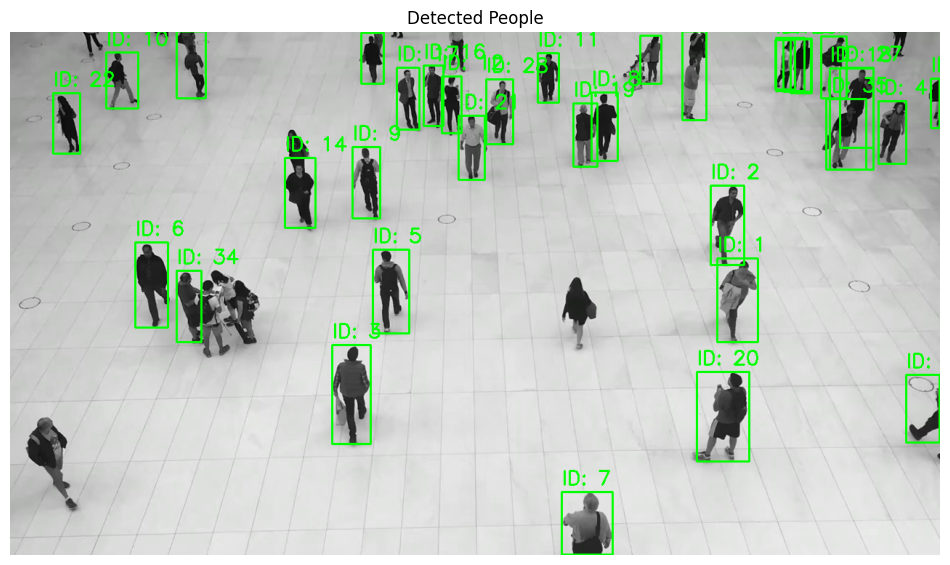

In [144]:
# Print information about detected people
if track_ids is not None and len(person_colors.keys()) > 0:
    print(f"Detected {len(track_ids)} people with the following IDs:")
    for i, (box, id) in enumerate(zip(boxes, track_ids)):
        x1, y1, x2, y2 = box.astype(int)
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        print(f"Person {id}: Position ({center_x}, {center_y})")

    # Display first frame with bounding boxes and IDs
    frame_with_boxes = frame.copy()
    for box, id in zip(boxes, track_ids):
        x1, y1, x2, y2 = box.astype(int)
        color = [int(c) for c in person_colors.get(id, (0, 255, 0))]  # Default to Green if ID not in colors
        cv2.rectangle(frame_with_boxes, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame_with_boxes, f"ID: {id}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(frame_with_boxes, cv2.COLOR_BGR2RGB))
    plt.title("Detected People")
    plt.axis('off')
    plt.show()

else:
    print("No people detected")
    cap.release()
    exit()

In [145]:
# Reset video capture to start
cap.release()
cap = cv2.VideoCapture(input_path)

In [146]:
# Process video frame by frame
frame_count = 0
print("Processing video...")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    if frame_count % 1 == 0:  # Progress update every 10 frames
        print(f"Processed {frame_count}/{total_frames} frames ({int(frame_count/total_frames*100)}%)")

    # Create a copy of the original frame
    output_frame = frame.copy()

    # Detect and track objects in the current frame
    results = model.track(frame, persist=True, classes=[0])

    if results[0].boxes.id is not None:
        boxes = results[0].boxes.xyxy.cpu().numpy()
        track_ids = results[0].boxes.id.cpu().numpy().astype(int)

        # Process all detected people
        for box, track_id in zip(boxes, track_ids):
            # We'll track all persons detected
            x1, y1, x2, y2 = box.astype(int)
            center_x = (x1 + x2) // 2
            center_y = (y1 + y2) // 2

            color = person_colors.get(track_id, (0, 255, 0))  # Default to white if ID not in colors

            # Update track history
            if track_id in track_history:
                track_history[track_id].append((center_x, center_y))
            else:
                track_history[track_id] = [(center_x, center_y)]

            # Draw the bounding box for this person
            cv2.rectangle(output_frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(output_frame, f"ID: {track_id}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

            # Draw the route on the route mask with the person's color
            points = track_history[track_id]
            if len(points) >= 2:
                for i in range(1, len(points)):
                    # Draw thick line with person's color
                    cv2.line(route_mask, points[i-1], points[i], color, 5)

    # Add the route mask to the output frame without transparency
    mask_indices = np.where(route_mask != 0)
    output_frame[mask_indices] = route_mask[mask_indices]

    # Write the frame to output video
    out.write(output_frame)

cap.release()
out.release()
print(f"Video processing complete, Output saved to {output_path}")

Processing video...
Processed 1/341 frames (0%)

0: 384x640 35 persons, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Processed 2/341 frames (0%)

0: 384x640 32 persons, 7.9ms
Speed: 2.1ms preprocess, 7.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
Processed 3/341 frames (0%)

0: 384x640 34 persons, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
Processed 4/341 frames (1%)

0: 384x640 34 persons, 7.1ms
Speed: 1.7ms preprocess, 7.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Processed 5/341 frames (1%)

0: 384x640 33 persons, 10.6ms
Speed: 2.1ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Processed 6/341 frames (1%)

0: 384x640 32 persons, 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
Processed 7/341 frames (2%)

0: 384x640 33 persons, 8.

In [147]:
files.download(output_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>